# Used modules

The following notebook relies on the module ensembler from Benjamin Ries, Stephanie M. Linker, David F. Hahn, Gerhard König, and Sereina Riniker
Journal of Chemical Information and Modeling 2021 61 (2), 560-564
DOI: 10.1021/acs.jcim.0c01283 

In [1]:
import numpy as np
from matplotlib import pyplot as plt

##Ensembler
import ensembler
from ensembler.analysis.freeEnergyCalculation import zwanzigEquation, threeStateZwanzig, bennetAcceptanceRatio

from ensembler.potentials import OneD as pot
from ensembler.samplers.stochastic import metropolisMonteCarloIntegrator
from ensembler.system.basic_system import system
from ensembler.system.perturbed_system import perturbedSystem
from ensembler.system.eds_system import edsSystem

#Enhanced sampling methods
from ensembler.ensemble import replica_exchange
from ensembler.ensemble import replicas_dynamic_parameters as cvb


from ensembler.visualisation.plotSimulations import oneD_simulation_analysis_plot

import matplotlib
from ensembler.visualisation import style
from ensembler.visualisation import plot_layout_settings
for key, value in plot_layout_settings.items():
    matplotlib.rcParams[key] = value


# Free energy calculations

In this notebook we will calculate free energy differences between two states, e.g. bound and unbound state of a protein-ligand complex or two conformational states.

Here, we will model those two states by a simplified 1D model consisting of two harmonic potentials with different potential energy minimum and curvature (force constant)

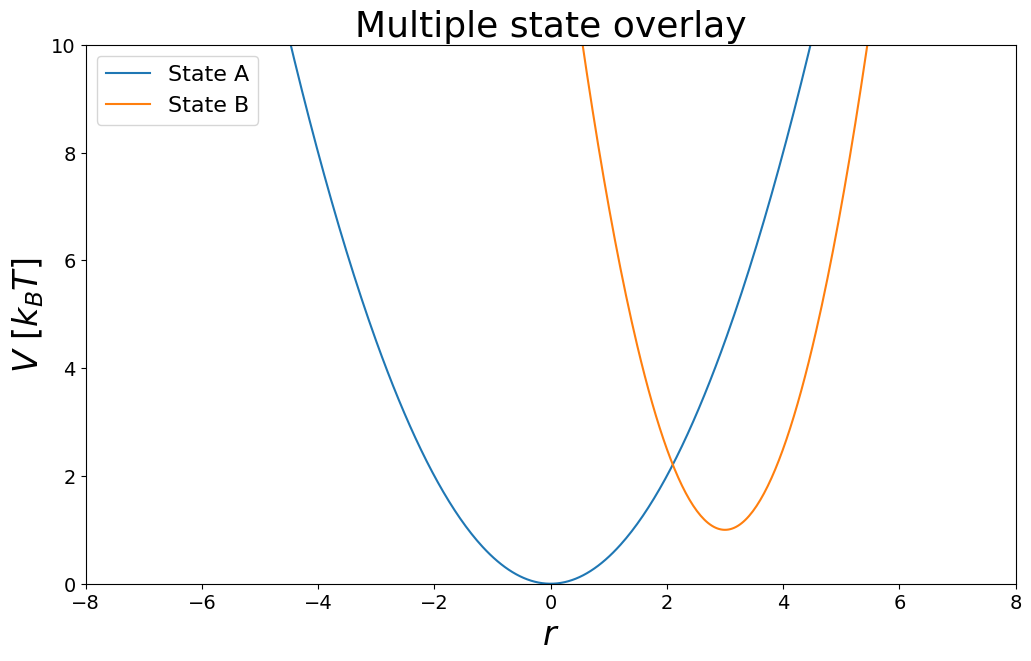

In [2]:
#Build System
#System Parameters:
yoff1 = 0
xoff1 = 0
# force_constant 
k1 = 1

# entropic_difference = force_constant
k2 = 3
# potential_difference
yoff2 = 1
# phase_space_distance
xoff2 = 3

#State Potentials
V_A = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1)
V_B = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

#Visualize
from ensembler.visualisation.plotPotentials import multiState_overlays

fig, _ = multiState_overlays([V_A,V_B])

## The Analyctical Solution
The Analytical solution for our problem can be calculated from the free energy of harmonic oscillators using

$F_i  = V_i - \frac{1}{2*\beta} log(\sqrt{\frac{2 \pi}{k_i \beta}})$.


As we know all parameters of the harmonic oscillators, we simply can calculate $F_i$ and $F_j$.
The difference of both quantities then results in the final free energy difference:

$\Delta F_{ij} = F_j - F_i$


In [3]:
#Analytical Solution
beta = 1 # beta is in kT

F_A = yoff1 -(1/(2*beta)) * np.log(np.sqrt((2*np.pi)/(k1*beta)))
F_B = yoff2 -(1/(2*beta)) * np.log(np.sqrt((2*np.pi)/(k2*beta)))
dF_AB_expected = F_B-F_A

print("expected dF: ", dF_AB_expected)

expected dF:  1.2746530721670273


For this toy example it was easy to calculate the free energy difference.
But there is not always an analytical solution our problem.
As the functional of a problem gets more complex we can not rely on an analytical solution anymore.
In the following we are going to discuss some methods, that can be used in cases like this.

## Free Energy Pertubation - BAR/Zwanzig: a simplistic start
The journey through the free energy method landscape is started with a simple start; The Free Energy Pertubation method.
As we now assume to not know the analytical solution, we could for example use one state and simulate it, to explore its potential landscape.
If the phase space overlap of both states is high, we could sample all the important information for both states, from this one simulation.



We are here using Monte Carlo simulations but Molecular Dynamics simulations could be used instead.

In [4]:
steps = simulation_steps_total_per_approach = 10000 #more steps better free energies, but if you just want to try 1000 ist quite fast.
equilibration_steps = simulation_steps_total_per_approach//10

space_range = [-5, 5] #This defines our one dimensional coordinate space
temperature = 30 # for the metropolis criterion of MMC sampler
sampler = metropolisMonteCarloIntegrator(step_size_coefficient=1) # With this algorithm wer are going to sample the potentials


### Sampling
Now we build first the two systems and run the simulations.

Simulation:  Simulation: 100%|██████████| 10000/10000 [00:00<00:00, 10735.27it/s]


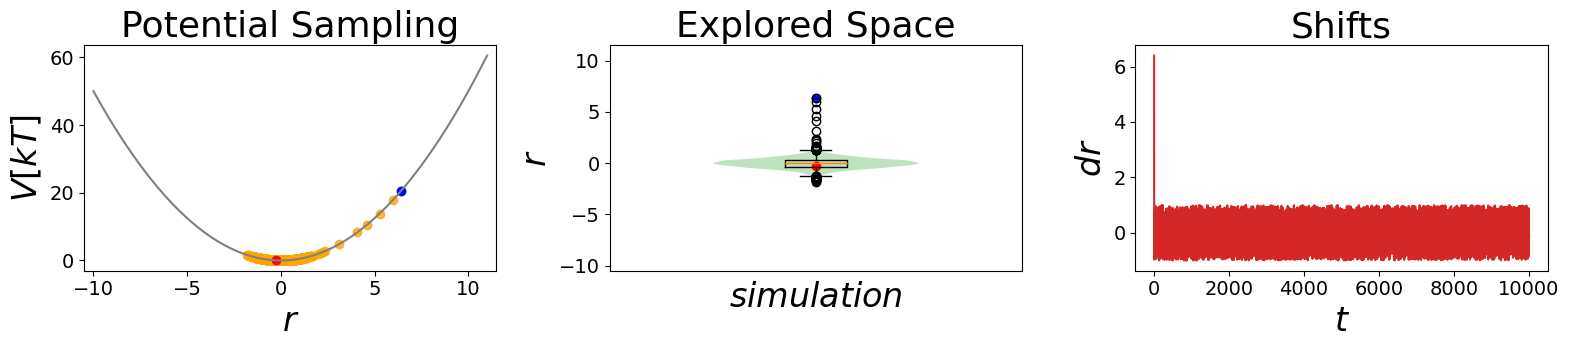

In [5]:
#Simulate the two states:
##Build Systems
systemA = system(potential=V_A, sampler=sampler, temperature=temperature)
systemB = system(potential=V_B, sampler=sampler, temperature=temperature)

##Simulate:
systemA.simulate(steps)
stateA_traj = systemA.trajectory
_ = oneD_simulation_analysis_plot(systemA, limits_coordinate_space=np.linspace(-10,10) )

### Analysis
After simulating state A, the potential energies for state B can be calculated using our potential fuction.

#### Zwanzig Equation
The Zwanzig equation is calculating the free energy difference of two states (A and B) sampled as an ensemble of one of the states (here A). The difference is boltzman-reweighted to increase the weight on the likely/favourable configurations.

$dF_{ij_{Zwanzig}}(V_i, V_j) = - \beta \ln(\langle e^{-\beta(V_j-V_i)} \rangle_i )$

In [6]:
VA_sampled_energies=stateA_traj.total_potential_energy[equilibration_steps:]
VB_sampled_energies=V_B.ene(stateA_traj.position[equilibration_steps:])

zwanz = zwanzigEquation(kT=True)
dF_AB_zwanzig = zwanz.calculate(Vi=VA_sampled_energies, Vj=VB_sampled_energies)

print("Expected Result: ", dF_AB_expected)
print("Zwanzig Result: ", dF_AB_zwanzig)
print()
print("Difference:", dF_AB_zwanzig - dF_AB_expected)

Expected Result:  1.2746530721670273
Zwanzig Result:  7.724225133818706

Difference: 6.449572061651679


#### Bennet Acceptance Ratio (BAR)
BAR requires one simulation of each state, to calculate the optimal path between both states. This is done in an iterative fashion. Usually BAR tends to give more accurate results than the Zwanzig approach.

Equation:
$dF_{ij_{BAR}}(V_i, V_j) = \ln(\frac{\langle f(V_i-Vj+C) \rangle_j}{\langle f(V_j-V_i-C) \rangle_i}) + C - ln(\frac{n_1}{n_0})$

with f as fermi function:
- $f(x) = \frac{1}{1+e^{-\beta x}}$

$dF_{ij_{BAR}}$ is calculated iterativley with $ddF_{ij_{BAR}}(V_i, V_j)$, till convergence

Simulation:  Simulation: 100%|██████████| 10000/10000 [00:01<00:00, 7242.59it/s]


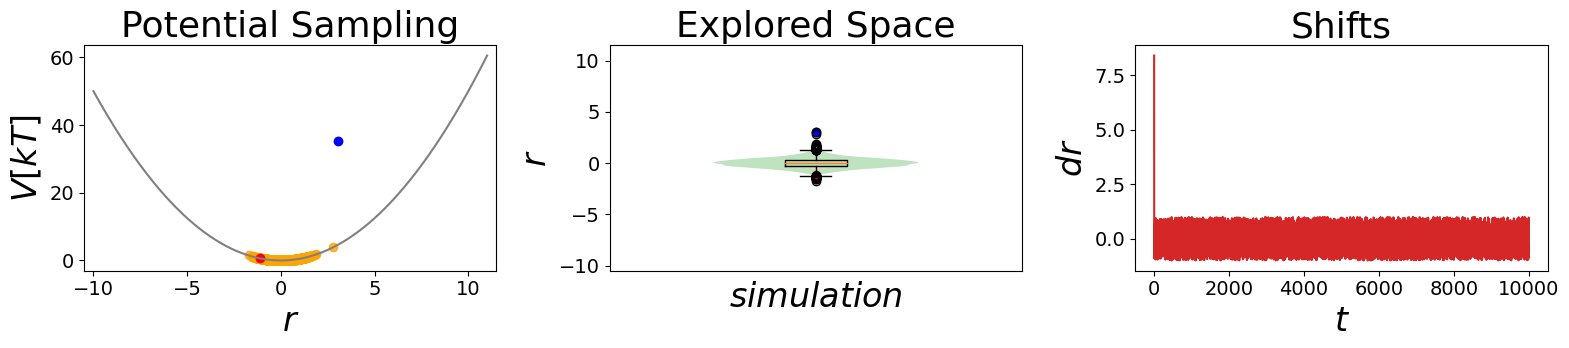

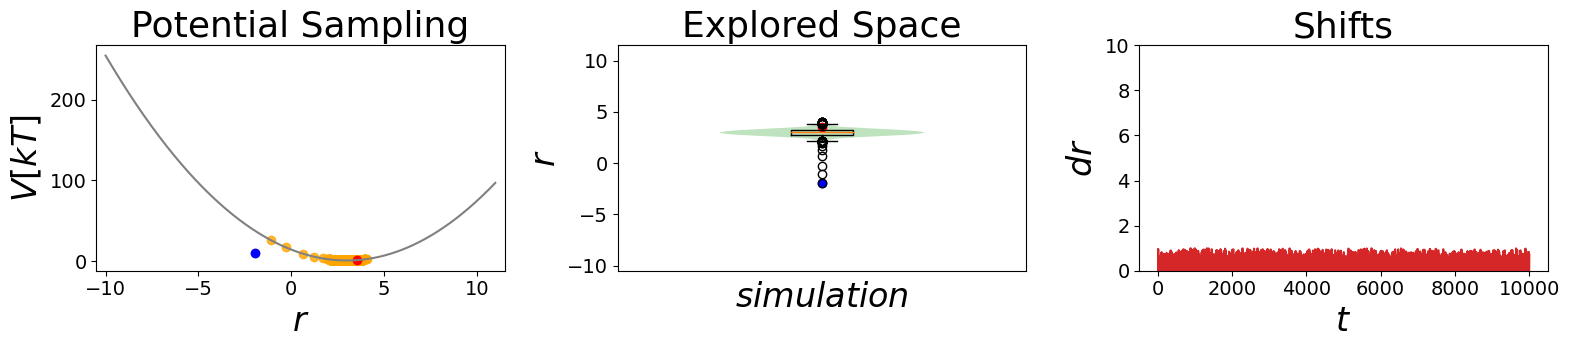

In [7]:
#Simulate the two states:
##Build Systems

systemA = system(potential=V_A, sampler=sampler, temperature=temperature)
systemB = system(potential=V_B, sampler=sampler, temperature=temperature)

##Simulate:
systemA.simulate(steps, withdraw_traj=True, init_system=True)
stateA_traj = systemA.trajectory
_ = oneD_simulation_analysis_plot(systemA, limits_coordinate_space=np.linspace(-10,10))

systemB.simulate(steps, withdraw_traj=True, init_system=True)
stateB_traj = systemB.trajectory

#visualize
_ = oneD_simulation_analysis_plot(systemB, limits_coordinate_space=np.linspace(-10,10))
plt.ylim([0,10])
pass

Text(0.5, 1.0, 'single state simulations')

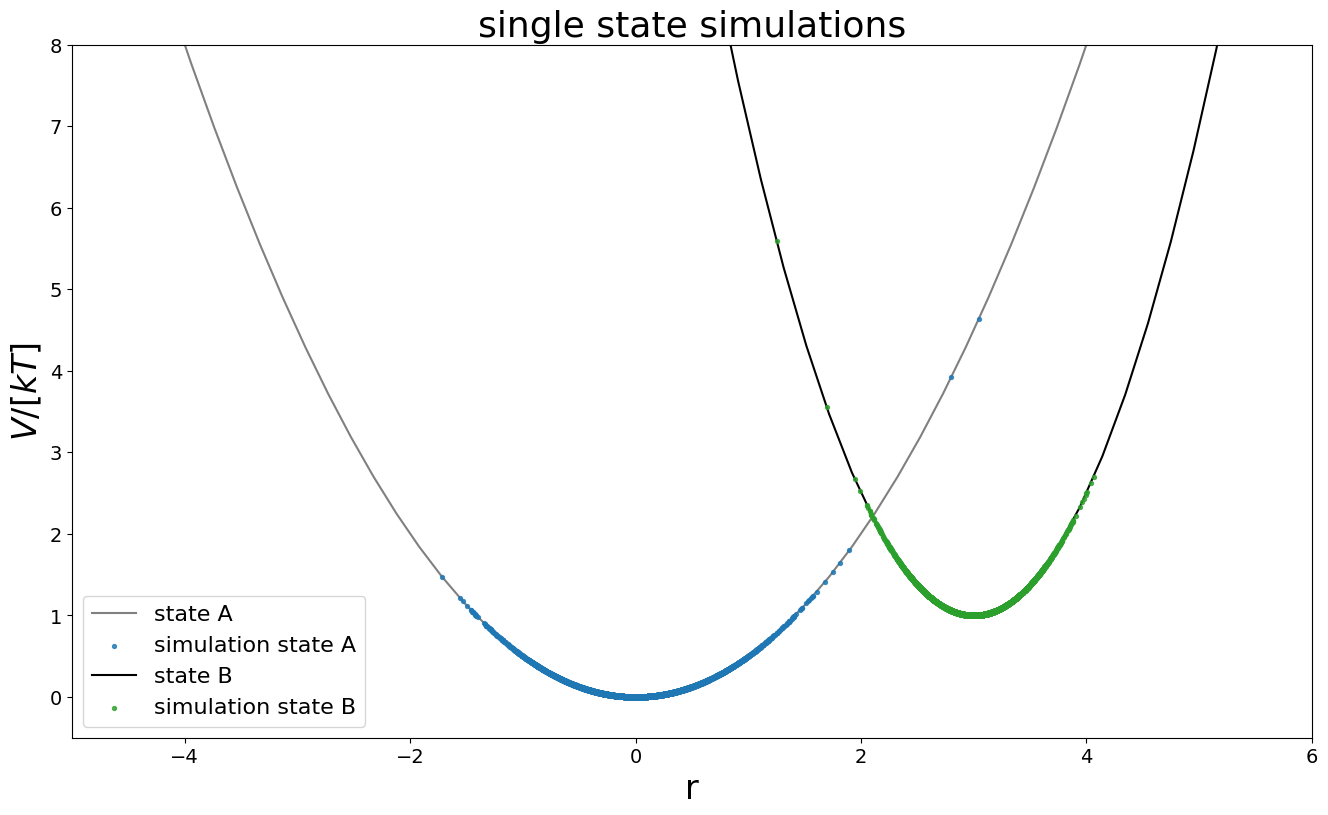

In [8]:
from ensembler import visualisation

positions = np.linspace(-10,10, 100)
fig, ax = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
ax = list([ax])
traj_pos = list(systemA.trajectory.position)
ax[0].plot(positions, systemA.potential.ene(positions), c="grey", label="state A", zorder=-10)
ene = systemA.potential.ene(traj_pos)
ax[0].scatter(traj_pos, ene, c="C0",alpha=0.8, label="simulation state A",s=8)
ax[0].set_ylim([0,8])

positions = np.linspace(-10,10, 100)
traj_pos = list(systemB.trajectory.position)
ax[0].plot(positions, systemB.potential.ene(positions), c="black", label="state B", zorder=-10)
ene = systemB.potential.ene(traj_pos)
ax[0].scatter(traj_pos, ene, c="C2",alpha=0.8, label="simulation state B",s=8)

ax[0].set_ylim([-0.5,8])
ax[0].set_xlim([-5,6])
ax[0].set_xlabel("r")
ax[0].set_ylabel("$V/[kT]$")
ax[0].legend()
ax[0].set_title("single state simulations")
#fig.savefig("freeEnergyPertubation.pdf")

In [9]:
#Sampling l1
V11=V_A.ene(stateA_traj.position)
V21=V_B.ene(stateA_traj.position)

#Sampling l2
V12=V_A.ene(stateB_traj.position)
V22=V_B.ene(stateB_traj.position)

bar = bennetAcceptanceRatio(kT=True, convergence_radius=0.01, max_iterations=1000)
dF_AB_bar = bar.calculate(Vj_i=V21, Vi_i=V11, Vi_j=V12, Vj_j=V22, verbose=True)

print()
print("Expected Result: ", dF_AB_expected)
print("BAR Result: ", dF_AB_bar)
print()
print("Difference:", dF_AB_bar - dF_AB_expected)

Iterate: 	convergence raidus: 0.01
Iteration: 0	dF: 4.679748794700983 	convergence 4.679748794700983
Iteration: 1	dF: 2.2575137058813457 	convergence 2.4222350888196376
Iteration: 2	dF: 3.3700345233936613 	convergence 1.1125208175123156
Iteration: 3	dF: 2.731228090479624 	convergence 0.6388064329140373
Iteration: 4	dF: 3.081458810005598 	convergence 0.3502307195259742
Iteration: 5	dF: 2.8823739165348075 	convergence 0.19908489347079072
Iteration: 6	dF: 2.993704196710059 	convergence 0.1113302801752516
Iteration: 7	dF: 2.9308034672541554 	convergence 0.06290072945590364
Iteration: 8	dF: 2.9661495731651035 	convergence 0.03534610591094811
Iteration: 9	dF: 2.9462243842401943 	convergence 0.019925188924909243
Iteration: 10	dF: 2.95743694250296 	convergence 0.011212558262765793
Iteration: 11	dF: 2.95112098748268 	convergence 0.00631595502028004

Final Iterations:  11  Result:  2.95112098748268

Expected Result:  1.2746530721670273
BAR Result:  2.95112098748268

Difference: 1.676467915315652

## Free energy perturbation
If the phase space overlap of the two state is low, the free energy estimate might deviate a lot from the real result.
This issue can be solved by coupling the phase space of the two states in a simulation.

In Free Energy Perturbation (FEP) we will couple the two phase spaces using $\lambda$-windows.

### $\lambda$ - Coupling
One way of coupling two states is to generate the linear combination of the hamiltonians and coupling them by a variable $\lambda$. A $\lambda=0$ corresponds here to state A and a $\lambda=1$ corresponds to state B. The equal mixutre is gained with $\lambda=0.5$. All other lambda values in between $[0,1]$ result in intermediate states, that can be used to bridge the two states phase space.
In the following we are going to build 10 lambda windows linearly distributed from 0 to 1. These will be used for simulations, that are finally analyzed by Zwanzig (resulting in Free energy pertubation (FEP) method).

Functional:

$H_{\lambda} = (1-\lambda) H_A + \lambda H_B$

Text(0.5, 1.0, 'Sampled Potentials')

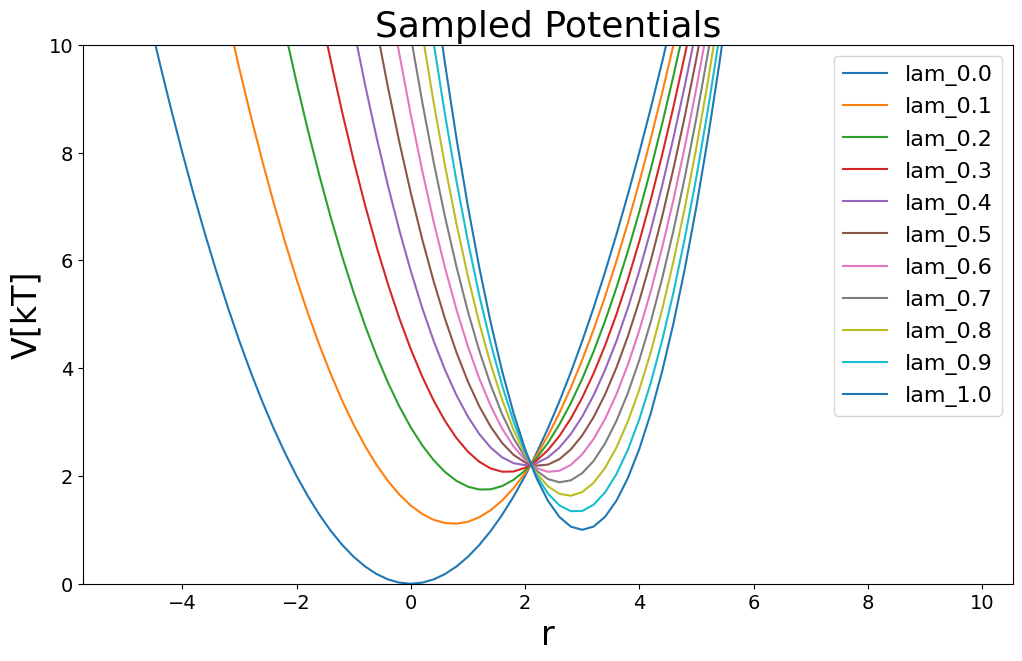

In [10]:
#Build Potential
V_perturbed = pot.linearCoupledPotentials(Va=V_A, Vb=V_B)

#Visualize
lambda_points = 11
positions = np.arange(-5,10, 0.2)
lambda_windows=np.linspace(0,1, lambda_points)

for lam in lambda_windows:
    V_perturbed.set_lambda(lam)
    ene =  V_perturbed.ene(positions)
    plt.plot(positions,ene, label="lam_"+str(round(lam, 2)))

plt.legend()

plt.ylim([0,10])
plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")

### Sampling
let's run simulations for all generated intermediate states:

In [11]:
perturbed_system = perturbedSystem(potential=V_perturbed, sampler=sampler, temperature=temperature)

system_trajs = {}
for lam in lambda_windows:
    perturbed_system.lam =lam 
    perturbed_system.simulate(steps, withdraw_traj=True, init_system=True)
    system_trajs.update({lam: perturbed_system.trajectory})


Simulation:  Simulation: 100%|██████████| 10000/10000 [00:02<00:00, 3763.65it/s]


### Analysis

First, let us check the sampling

(-5.0, 6.0)

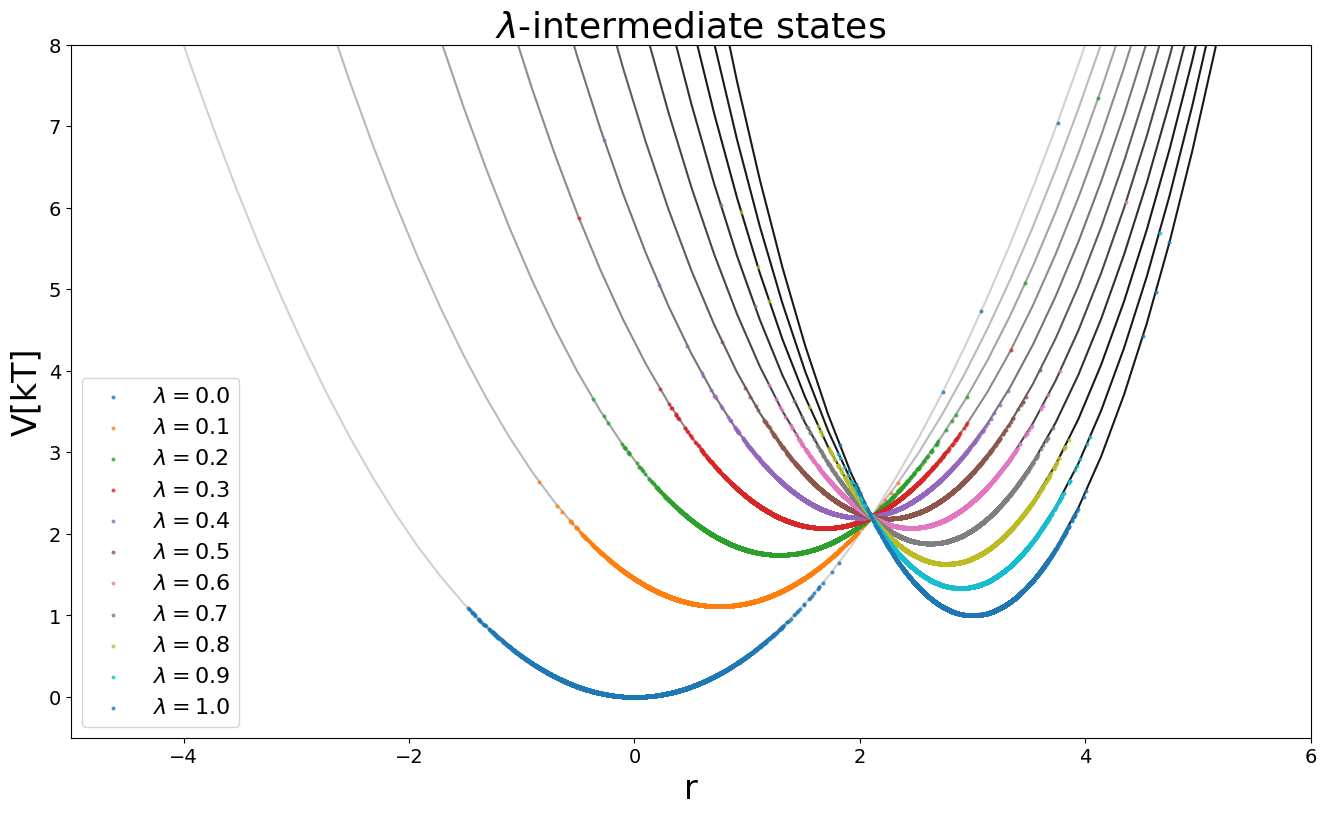

In [12]:
from ensembler import visualisation
from matplotlib import cm
#Visualize
positions = np.linspace(-10, 10, 100)
y_range = [-0.5, 8]


fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
axes = list([axes])
enes = []
all_lams = sorted(list(system_trajs.keys()))

for lamI in all_lams:
    trajI = system_trajs[lamI]
    V_perturbed.set_lambda(lamI)
    ene =  V_perturbed.ene(positions)
    enes.append(ene)
    if(lamI==1):
        c="black"
    else:
        c = cm.get_cmap("binary")(lamI+0.2)

    axes[0].plot(positions,ene, c=c, zorder=-10,alpha=0.9)
    axes[0].scatter(trajI.position, V_perturbed.ene(trajI.position),s=8,alpha=0.8, linewidths=0,
                    label="$\lambda=$"+str(round(lamI, 2)),)#c="orange")

logExp=list(map(lambda x: np.log(np.exp(x)), enes))

axes[0].legend()
axes[0].set_ylim(y_range)

axes[0].set_ylabel("V[kT]")
axes[0].set_xlabel("r")
axes[0].set_title("$\lambda$-intermediate states")

axes[0].set_xlim([-5,6])


### FEP with multiple lambda windows:
This method is calculating the energy difference between the different $\lambda$-points using the Zwanzig equation leading to a path from state A to state B.


Expected Result:  1.2746530721670273
Sum of intermediates Result:  2.110949607172538

Difference: 0.8362965350055109


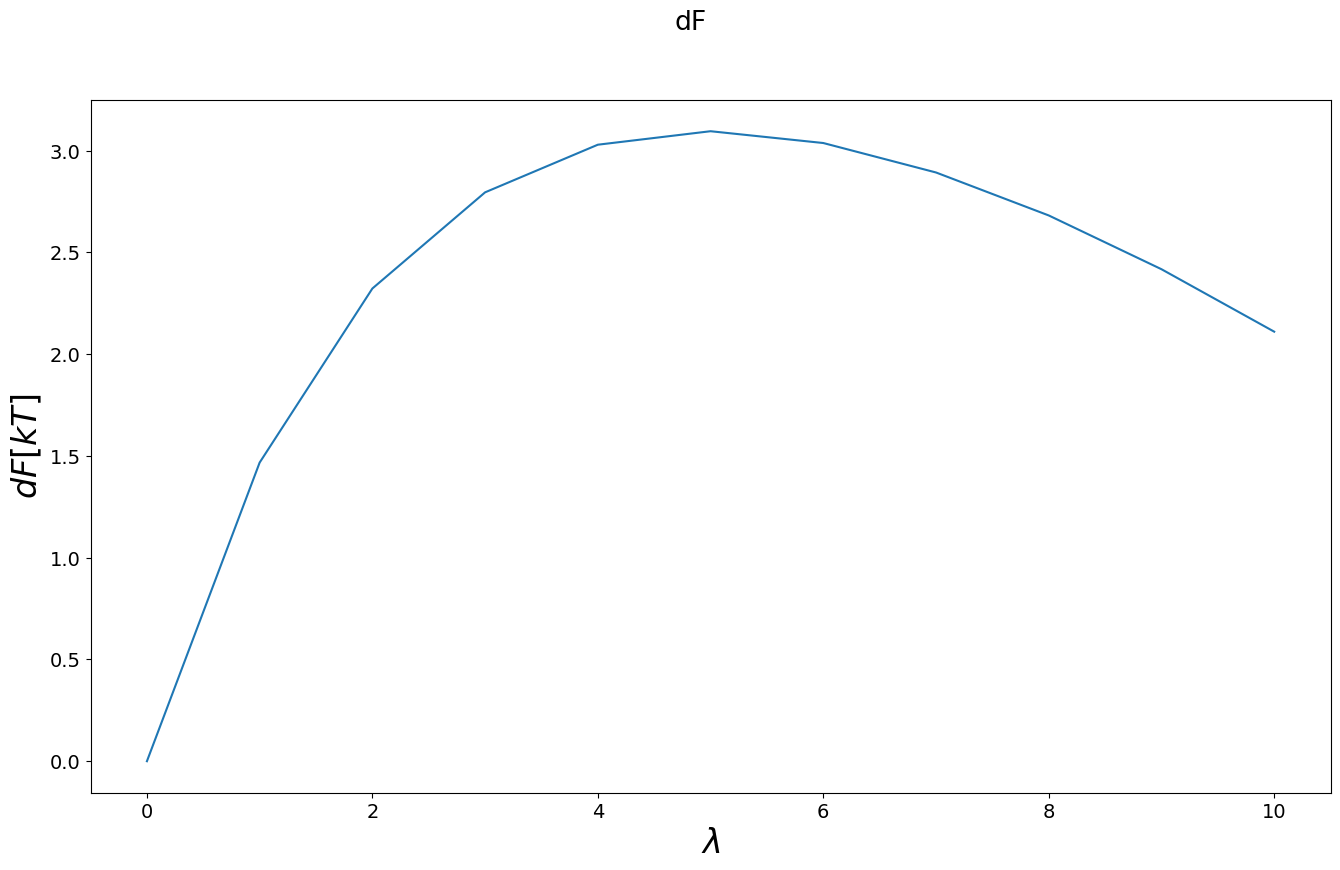

In [13]:
dA_i_fw = []
ddA_i_fw = []
cur_ddA = 0.0
ddA_i_fw.append(cur_ddA)
zwanz = zwanzigEquation()
all_lams = list(sorted(list(system_trajs.keys())))
for lamI, lamJ in zip(all_lams, all_lams[1:]):
    trajI = system_trajs[lamI]
    #trajJ = system_trajs[lamJ]

    #Vi_fw = trajI.total_potential_energy
    #Vj_fw = trajJ.total_potential_energy
    V_perturbed.set_lambda(lamJ)

    Vi_fw = trajI.total_potential_energy[equilibration_steps:]
    Vj_fw = V_perturbed.ene(trajI.position[equilibration_steps:])

    dF_zwanzig_fw = zwanz.calculate(Vi=Vi_fw, Vj=Vj_fw)

    dA_i_fw.append(dF_zwanzig_fw)
    cur_ddA += dF_zwanzig_fw
    ddA_i_fw.append(cur_ddA)

fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
axes.plot(ddA_i_fw)
axes.set_ylabel("$dF [kT]$")
axes.set_xlabel("$\lambda$")

fig.suptitle("dF")

dF_AB_FEP_10lambda = np.sum(dA_i_fw)

print()
print("Expected Result: ", dF_AB_expected)
print("Sum of intermediates Result: ", dF_AB_FEP_10lambda)
print()
print("Difference:", dF_AB_FEP_10lambda - dF_AB_expected)

### BAR

Now we will use BAR on all lambda windows

Iterate: 	convergence raidus: 0.01
Iteration: 0	dF: 1.2715772575515063 	convergence 1.2715772575515063
Iteration: 1	dF: 1.1455893347438253 	convergence 0.125987922807681
Iteration: 2	dF: 1.1593767835278854 	convergence 0.01378744878406013
Iteration: 3	dF: 1.1578702316229212 	convergence 0.0015065519049641818

Final Iterations:  3  Result:  1.1578702316229212
Iterate: 	convergence raidus: 0.01
Iteration: 0	dF: 0.7070803104029936 	convergence 0.7070803104029936
Iteration: 1	dF: 0.6594422866754032 	convergence 0.047638023727590406
Iteration: 2	dF: 0.6627887256251794 	convergence 0.0033464389497762648

Final Iterations:  2  Result:  0.6627887256251794
Iterate: 	convergence raidus: 0.01
Iteration: 0	dF: 0.3676604525422357 	convergence 0.3676604525422357
Iteration: 1	dF: 0.3519583725253018 	convergence 0.015702080016933906
Iteration: 2	dF: 0.3526396310396455 	convergence 0.0006812585143436967

Final Iterations:  2  Result:  0.3526396310396455
Iterate: 	convergence raidus: 0.01
Iteration: 0	d

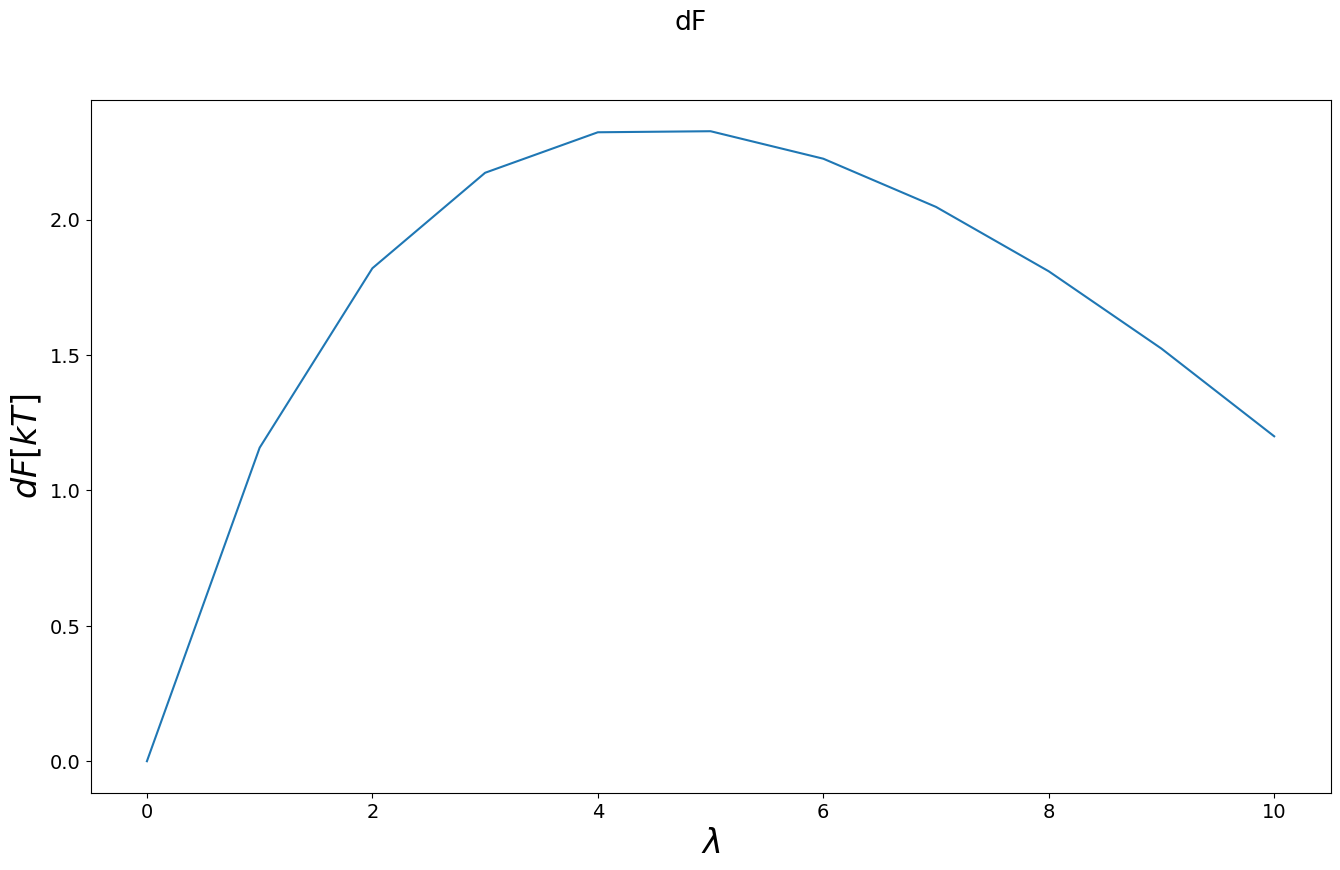

In [14]:
dA_ij= []
ddA_ij = []
cur_ddA = 0.0
ddA_ij.append(cur_ddA)

all_lams = list(sorted(list(system_trajs.keys())))
for lamI, lamJ in zip(all_lams, all_lams[1:]):
    trajI = system_trajs[lamI]
    trajJ = system_trajs[lamJ]

    #Vi_fw = trajI.total_potential_energy
    #Vj_fw = trajJ.total_potential_energy
    V_perturbed.set_lambda(lamJ)
    V11 = trajI.total_potential_energy[equilibration_steps:]
    V21 = V_perturbed.ene(trajI.position[equilibration_steps:])

    V_perturbed.set_lambda(lamI)
    V22 = trajJ.total_potential_energy[equilibration_steps:]
    V12 = V_perturbed.ene(trajJ.position[equilibration_steps:])

    dA = bar.calculate(Vj_i=V21, Vi_i=V11, Vi_j=V12, Vj_j=V22, verbose=True)

    dA_ij.append(dA)
    cur_ddA += dA
    ddA_ij.append(cur_ddA)

fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
axes.plot(ddA_ij)
axes.set_ylabel("$dF [kT]$")
axes.set_xlabel("$\lambda$")

fig.suptitle("dF")

dF_AB_FEP_10lambda = np.sum(dA_ij)

print()
print("Expected Result: ", dF_AB_expected)
print("Sum of intermediates Result: ", dF_AB_FEP_10lambda)
print()
print("Difference:", dF_AB_FEP_10lambda - dF_AB_expected)